Restructuring inspired by [photometry_from_aec_emulator.ipynb](photometry_from_aec_emulator.ipynb) and some discussion w/ Michelle.

In [213]:
import time
import functools
import multiprocessing
from pathlib import Path
from copy import deepcopy
from collections import defaultdict

import numpy as np

from scipy import integrate

from astropy import units as u
from astropy import table
from astropy.io import fits
from astropy.modeling import models, fitting

from astroquery.svo_fps import SvoFps


from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


In [7]:
datapath = Path('../fullgrid/')

# Load Data

Mostly taken from [resampling_tensors.ipynb](resampling_tensors.ipynb)

In [8]:
wlspath = datapath / 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

wlsraw = fits.getdata(wlspath)
model_wls = wlsraw << u.Unit(fits.getheader(wlspath)['UNIT'])

model_wls, len(model_wls)

(<Quantity [  500.  ,   500.1 ,   500.2 , ..., 54999.25, 54999.5 , 54999.75] Angstrom>,
 1569128)

In [9]:
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
len(allspecpaths)

7559

But some of them have no BUINT, it turns out those are wrong in an unclear way so we skip them.

In [10]:
goodspecpaths = [p for p in tqdm(allspecpaths) if 'BUNIT' in fits.getheader(p)]
len(goodspecpaths)

  0%|          | 0/7559 [00:00<?, ?it/s]

7508

In [11]:
specunit = u.Unit(fits.getval(goodspecpaths[0], 'BUNIT'))

# Pick bands and wavelength range

This sets up a wavelength range for interpolation that spans a specific set of photometic bands at a wavelength spacing that is not-crazy for the filter responses available.

In [12]:
filters = ['HST/WFC3_UVIS1.F275W', 'HST/WFC3_UVIS1.F336W', 
           'HST/ACS_WFC.F475W', 'HST/ACS_WFC.F814W', 
           'HST/WFC3_IR.F110W', 'HST/WFC3_IR.F160W']

transmission = {filtname.split('.')[-1]:SvoFps.get_transmission_data(filtname) for filtname in filters}

In [13]:
wls = [u.Quantity(ttab['Wavelength'], u.angstrom) for ttab in transmission.values()]

dwls = []
for wl in wls:
    dwls.append(np.diff(wl))
dwls = np.concatenate(dwls)

qs = np.quantile(dwls, [.01, .05, .1, .5, .9])
qs

<Quantity [4.880000e-04, 4.995120e-01, 5.000000e-01, 5.000000e-01,
           3.592285e+00] Angstrom>

In [14]:
dwl = qs[2]
dwl

<Quantity 0.5 Angstrom>

In [15]:
minwl = np.concatenate(wls).min()
maxwl = np.concatenate(wls).max()
minwl, maxwl

(<Quantity 2161. Angstrom>, <Quantity 17204.697266 Angstrom>)

In [16]:
minwl

<Quantity 2161. Angstrom>

In [17]:
(minwl.to(u.angstrom), maxwl.to(u.angstrom), dwl.to(u.angstrom))

(<Quantity 2161. Angstrom>,
 <Quantity 17204.697266 Angstrom>,
 <Quantity 0.5 Angstrom>)

In [18]:
(maxwl-minwl)//dwl  + 1

<Quantity 30088.>

In [19]:
fine_wl = np.linspace(minwl.to(u.angstrom)*.99, maxwl.to(u.angstrom)*1.01, int((maxwl*1.01-minwl*.99)//dwl  + 1))
len(fine_wl)

30475

that's way too fine to realistically train.  Lets try shrinking it down for now and see if it works ok anyway.

In [20]:
data_wls = fine_wl[::10]
len(data_wls)

3048

# Do the interpolation to more reasonable-size spectra

note this caches the result in `fluxes.pt`.  Delete the file to re-compute

In [21]:
fluxes = None
if Path('fluxes.pt').is_file():
    fluxes = torch.load('fluxes.pt', weights_only=True)

In [23]:
if fluxes is None:
    resampler = manipulation.FluxConservingResampler()
    
    def interpolate_and_return_flux(specpath, data_wls=data_wls, resampler=resampler):
        header = dict(fits.getheader(specpath, ext=0))
        spec = Spectrum1D(spectral_axis=model_wls, flux=fits.getdata(specpath, ext=0) << u.Unit(header['BUNIT']))
        newspec = resampler(spec, data_wls)
    
        return newspec.flux.value
    
    with multiprocessing.Pool(16) as pool:
          results = list(tqdm(pool.imap(interpolate_and_return_flux, goodspecpaths), total=len(goodspecpaths)))
        
    fluxes = torch.from_numpy(np.array(results))
    torch.save(fluxes, 'fluxes.pt')

fluxes.shape

  0%|          | 0/7508 [00:00<?, ?it/s]

torch.Size([7508, 3048])

In [24]:
teff = torch.tensor([fits.getval(p, 'PHXTEFF') for p in goodspecpaths])
logg = torch.tensor([fits.getval(p, 'PHXLOGG') for p in goodspecpaths])
feh = torch.tensor([fits.getval(p, 'PHXM_H') for p in goodspecpaths])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

# Timing and accuracy tests for black body flux scaling

Text(0, 0.5, 'time [ms]')

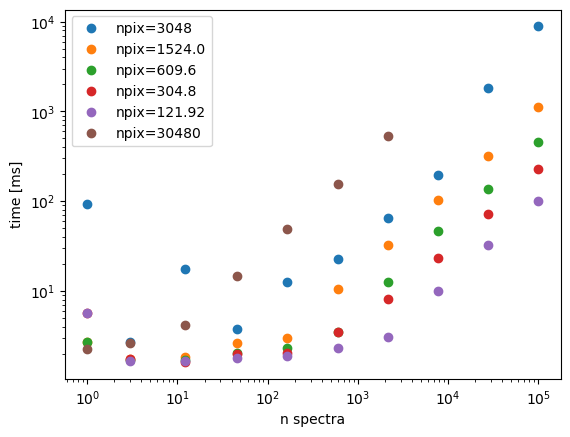

In [25]:
def ttest(n, wls):
    t = np.random.rand(n)*10000 + 2000
    
    st = time.time()
    bb = models.BlackBody(temperature=t*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    flux = bb(wls[..., None])*(np.pi*u.sr)
    mf = np.mean(flux, axis=0)
    mfv = torch.from_numpy(mf.value) # not always necessary but just in case
    et = time.time()
    
    return mf, 1000*(et-st) # time in millisec

ns = np.logspace(0, 5, 10).astype(int)
times = [ttest(ni, data_wls)[1] for ni in ns]
times2 = [ttest(ni, data_wls[::2])[1] for ni in ns]
times5 = [ttest(ni, data_wls[::5])[1] for ni in ns]
times10 = [ttest(ni, data_wls[::10])[1] for ni in ns]
times25 = [ttest(ni, data_wls[::25])[1] for ni in ns]
wlx10 = np.linspace(data_wls[0], data_wls[-1], len(data_wls)*10)
timesx10 = [ttest(ni, wlx10)[1] for ni in ns[:-3]]
plt.loglog(ns, times, 'o', label=f'npix={len(data_wls)}')
plt.loglog(ns, times2, 'o', label=f'npix={len(data_wls)/2}')
plt.loglog(ns, times5, 'o', label=f'npix={len(data_wls)/5}')
plt.loglog(ns, times10, 'o', label=f'npix={len(data_wls)/10}')
plt.loglog(ns, times25, 'o', label=f'npix={len(data_wls)/25}')
plt.loglog(ns[:-3], timesx10, 'o', label=f'npix={len(data_wls)*10}')
plt.legend(loc=0)
plt.xlabel('n spectra')
plt.ylabel('time [ms]')

There's a floor of ~ a few msecs, which might be a bit on the slow side. Seems like it scales for reasonable batch sizes until we get to thousands of pixels.  Is that good enough?

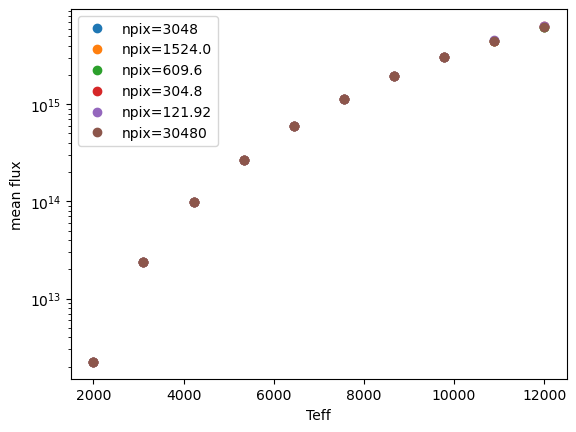

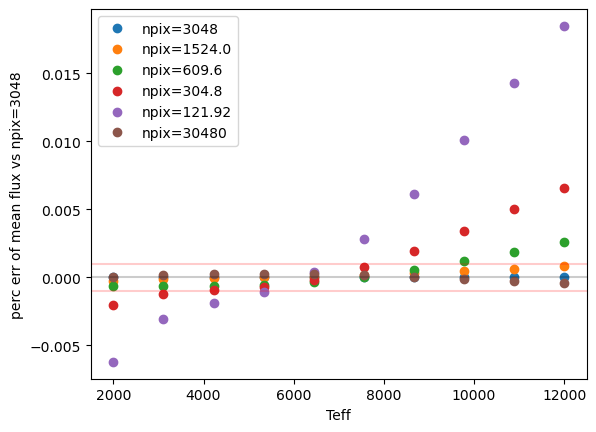

In [26]:
def mtest(nteffs, wls):
    t = np.linspace(2000,12000,nteffs)*u.K
    
    bb = models.BlackBody(temperature=t, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    flux = bb(wls[..., None])*(np.pi*u.sr)
    mf = np.mean(flux, axis=0)
    mfv = torch.from_numpy(mf.value) # not always necessary but just in case
    
    return t, mf

n = 10
teffs, means = mtest(n, data_wls)
means2 = mtest(n, data_wls[::2])[1]
means5 = mtest(n, data_wls[::5])[1]
means10 = mtest(n, data_wls[::10])[1]
means25 = mtest(n, data_wls[::25])[1]
wlx10 = np.linspace(data_wls[0], data_wls[-1], len(data_wls)*10)
meansx10 = mtest(n, wlx10)[1]

plt.semilogy(teffs, means, 'o', label=f'npix={len(data_wls)}')
plt.semilogy(teffs, means2, 'o', label=f'npix={len(data_wls)/2}')
plt.semilogy(teffs, means5, 'o', label=f'npix={len(data_wls)/5}')
plt.semilogy(teffs, means10, 'o', label=f'npix={len(data_wls)/10}')
plt.semilogy(teffs, means25, 'o', label=f'npix={len(data_wls)/25}')
plt.semilogy(teffs, meansx10, 'o', label=f'npix={len(data_wls)*10}')
plt.legend(loc=0)
plt.xlabel('Teff')
plt.ylabel('mean flux')

plt.figure()

plt.plot(teffs, means / means - 1, 'o', label=f'npix={len(data_wls)}')
plt.plot(teffs, means2 / means - 1, 'o', label=f'npix={len(data_wls)/2}')
plt.plot(teffs, means5 / means - 1, 'o', label=f'npix={len(data_wls)/5}')
plt.plot(teffs, means10 / means - 1, 'o', label=f'npix={len(data_wls)/10}')
plt.plot(teffs, means25 / means - 1, 'o', label=f'npix={len(data_wls)/25}')
plt.plot(teffs, meansx10 / means - 1, 'o', label=f'npix={len(data_wls)*10}')
plt.axhline(0, c='k', alpha=.2)
plt.axhline(0.001, c='r', alpha=.2)
plt.axhline(-0.001, c='r', alpha=.2)
plt.legend(loc=0)
plt.xlabel('Teff')
plt.ylabel(f'perc err of mean flux vs npix={len(data_wls)}');

Hmm, so there is a few ppt error at < 1000 pixels.  What about a grid interpolation? Lets try using the actually teffs present:

In [27]:
uteffs = np.unique(teff)*u.K
uteffs.shape, uteffs

((73,),
 <Quantity [ 2300.,  2400.,  2500.,  2600.,  2700.,  2800.,  2900.,  3000.,
             3100.,  3200.,  3300.,  3400.,  3500.,  3600.,  3700.,  3800.,
             3900.,  4000.,  4100.,  4200.,  4300.,  4400.,  4500.,  4600.,
             4700.,  4800.,  4900.,  5000.,  5100.,  5200.,  5300.,  5400.,
             5500.,  5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,
             6300.,  6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,
             7200.,  7400.,  7600.,  7800.,  8000.,  8200.,  8400.,  8600.,
             8800.,  9000.,  9200.,  9400.,  9600.,  9800., 10000., 10200.,
            10400., 10600., 10800., 11000., 11200., 11400., 11600., 11800.,
            12000.] K>)

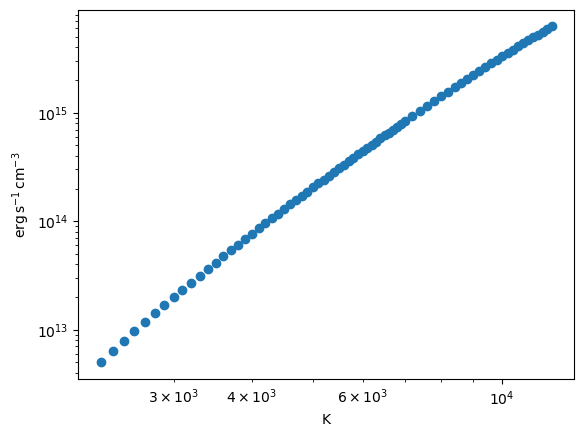

In [28]:
bb = models.BlackBody(temperature=uteffs, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
flux = bb(wlx10[..., None])*(np.pi*u.sr)
mf = np.mean(flux, axis=0)
plt.loglog(uteffs, mf, 'o')

Close to a power law.  Good enough?

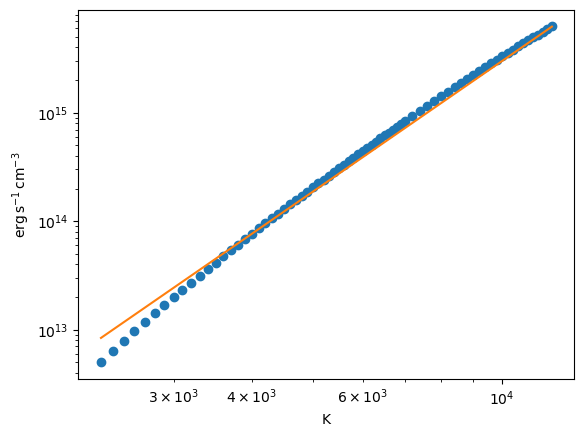

In [29]:
pl = models.PowerLaw1D(.3, 1*u.K, -4)

plt.loglog(uteffs, mf, 'o')
plt.plot(uteffs, pl(uteffs).value)

Not good enough.  Polynomial in log-space?

(0.2281665802001953, 73, <Quantity 5.42194705e-09>, <Quantity 0.00010491>)

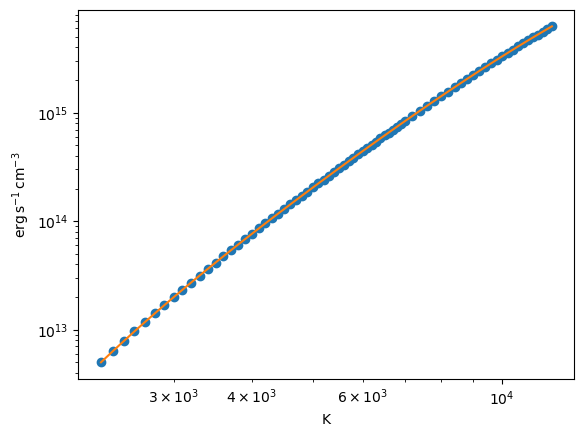

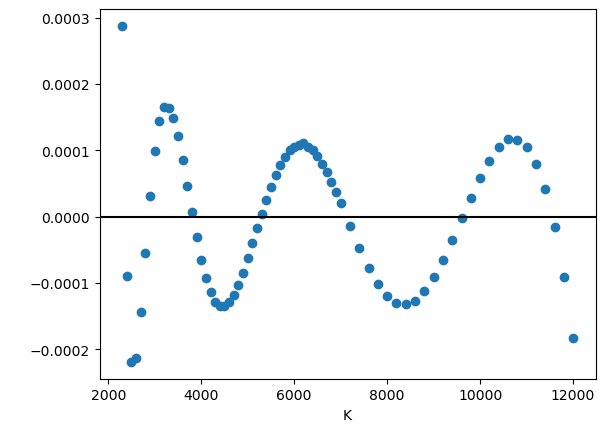

In [30]:
teffpoly = fitting.LinearLSQFitter()(models.Polynomial1D(6), np.log10(uteffs/u.K), np.log10(mf.value))

plt.loglog(uteffs, mf, 'o')
plt.plot(uteffs, 10**teffpoly(np.log10(uteffs/u.K)).value)

plt.figure()
percerror = 10**teffpoly(np.log10(uteffs/u.K))/mf.value - 1
plt.plot(uteffs, percerror, 'o')
plt.axhline(0,c='k')


st = time.time() 
teffpoly(np.log10(uteffs/u.K))
et = time.time()
(et-st)*1000, len(uteffs), np.mean(percerror), np.std(percerror)

# Create the Model

The model here is a few layered components:
* MLP from the input feature space to some fixed size restricted "latent-like" space.
* A resnet-style expansion from the latent space to the pixel space

In [31]:
class SpectrumEmulator(nn.Module):
    def __init__(self, feature_mlp_nneurons, resnet_nneurons, teffindex=0, 
                       logifyteff=False, data_wls=data_wls, activation_cls=nn.GELU):
        """
        output pixels implicitly set by data_wls, input by first of feature_mlp_nneurons
        """
        super().__init__()

        self.data_wls = data_wls.to(u.angstrom)
        self.teffindex = teffindex
        self.logifyteff = logifyteff
        
        noutpixels = len(data_wls)

        mlp_layers = []
        for ni, no in zip(feature_mlp_nneurons[:-1], feature_mlp_nneurons[1:]):
            mlp_layers.append(nn.Linear(ni, no))
            mlp_layers.append(activation_cls())


        self.mlp = nn.Sequential(*mlp_layers)

        assert feature_mlp_nneurons[-1] == resnet_nneurons[0], 'the mlp must end with the same number of neurons as the resnet starts with!' 
        assert resnet_nneurons[0] == resnet_nneurons[-1], 'the resnet must start and end at the same number of neurons'

        res_layers = []
        for ni, no in zip(resnet_nneurons[:-1], resnet_nneurons[1:]):
            res_layers.append(nn.Linear(ni, no))
            res_layers.append(activation_cls())
        
        self.resishnet = nn.Sequential(*res_layers)

        self.outputnet = nn.Sequential(nn.Linear(resnet_nneurons[-1], noutpixels),
                                       activation_cls(),
                                       nn.Linear(noutpixels, noutpixels),
                                      )

        self.loss_fcn = nn.MSELoss()
        self.optimizer_cls = torch.optim.AdamW
        self.scheduler_init = None

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype

    def bbscale(self, flux, teff):
        bbmean = self.bbmean(teff)
        y = flux/bbmean - 1
        return y

    def bbunscale(self, y, teff):
        bbmean = self.bbmean(teff)
        flux = (y + 1) * bbmean
        return flux

    def bbmean(self, teff):
        # fast approximation from above
        if isinstance(teff, u.Quantity):
            teff = teff/u.K
        if isinstance(teff, torch.Tensor):
            teff = teff.to('cpu')
        res = 10**teffpoly(np.log10(teff))
        return self.convert_input(torch.from_numpy(res.value))
        
    def bbmean_direct(self, teff):
        """
        teff should be scalar or 1d
        """
        # TODO: implement caching if needed
        bb = models.BlackBody(temperature=teff, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
        flux = bb(self.data_wls[..., None])*(np.pi*u.s)
        return flux.mean(axis=0)

    def convert_input(self, t):
        t = torch.atleast_2d(t)
        return t.to(self.device, dtype=self.dtype)

    def forward(self, x, in_convert=True):
        """
        the output is not descaled here, use `forward_descale` if that's what's desired
        """
        if in_convert:
            x = self.convert_input(x)
        
        if self.logifyteff:
            x = x.copy()
            x[..., self.teffindex] = torch.log10(x[..., self.teffindex])
    
        ym = self.mlp(x)
        yr = self.resishnet(ym)
        return self.outputnet(yr + ym)
            
    def forward_descale(self, x, in_convert=True):
        if in_convert:
            x = self.convert_input(x)
        return self.bbunscale(self.forward(x), x[..., self.teffindex])

    def train_and_validate(self, infeatures, fluxes, nepochs, batch_size,
                                 tetrsplit=[.3, .7], split_seed=42, optkwargs={}, shuffle_batches=True):
        inteff = infeatures[..., self.teffindex][..., None]
        scaled_fluxes = self.bbscale(self.convert_input(fluxes), inteff)
        dataset = TensorDataset(self.convert_input(infeatures), scaled_fluxes)
        
        split_data = random_split(dataset, tetrsplit, torch.Generator().manual_seed(split_seed))
        valid_data, train_data = split_data

        optimizer = self.optimizer_cls(self.parameters(), **optkwargs)
        if self.scheduler_init is not None:
            scheduler = self.scheduler_init(optimizer)
            
        niters = 0
        valid_losses = []
        valid_niters = []    
        train_losses = []
        train_niters = []
        lrs = []

        valid_x = valid_data.dataset.tensors[0][valid_data.indices]
        valid_y = valid_data.dataset.tensors[1][valid_data.indices]
        def validation_fcn():
            self.eval()
            with torch.no_grad():
                pred = self(valid_x, in_convert=False)
                valid_loss = self.loss_fcn(pred, valid_y).item()
                valid_losses.append(valid_loss)
                valid_niters.append(niters)
            return valid_loss

        for _ in (pbar := tqdm(range(nepochs))):
            self.train()

            for data in DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_batches):
                X, Y = data[:2]
                optimizer.zero_grad()
                
                pred = self(X, in_convert=False)
                loss = self.loss_fcn(pred, Y)
                
                loss.backward()
                optimizer.step()
        
                niters += X.shape[0]
                
                train_losses.append(loss.item())
                train_niters.append(niters)

            if self.scheduler_init is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
            valid_loss = validation_fcn()
            if self.scheduler_init  is None:
                pbar.set_description(f'valid loss={valid_loss:.3e}')
            else:
                pbar.set_description(f'valid loss={valid_loss:.3e}, lr={lrs[-1][0]:.3e}')

        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data
        

In [32]:
def plot_sample_specs(model, dataset_to_plot, idxs=5, descale=False, wlrng=(14000*u.angstrom, 15000*u.angstrom)):
    if isinstance(idxs, int):
        idxs = np.random.randint(len(dataset_to_plot), size=5)

    wl = model.data_wls

    figs = []
    for idx in idxs:
        true_idx = dataset_to_plot.indices[idx]
        Xi, Yi = [xy[true_idx] for xy in dataset_to_plot.dataset.tensors]
        
        pred = model(Xi[None,...])[0].detach()
        if descale:
            teffs = model.convert_input(Xi[..., model.teffindex][..., None])
            pred = model.bbunscale(pred, teffs)[0]
            Yi = model.bbunscale(Yi, teffs)[0]
            
        fig, axs = plt.subplots(1, 3, figsize=(12, 6))
        figs.append(fig)
        ax1, ax2, ax3 = axs
        
        ax1.plot(wl, Yi.cpu(), lw=1, label='true')
        ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
        ax1.legend(loc=0)
        ax1.set_title(f'{idx}')
        
        msk = (wlrng[0]<model.data_wls)&(model.data_wls<wlrng[1])
        ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
        ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
        ax2.legend(loc=0)
        ax2.set_title(f'{true_idx} - zoom')
        
        ax3.plot(wl, (Yi.cpu()-pred.cpu())/Yi.cpu(), lw=1, label='true')
        ax3.set_title(f'{true_idx} - frac residual')
        
    return figs

In [35]:
90*60*7

37800

In [34]:
60*7

420

46.933112 M parameters


/tmp/ipykernel_23330/563349319.py:66: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = 10**teffpoly(np.log10(teff))


  0%|          | 0/40000 [00:00<?, ?it/s]

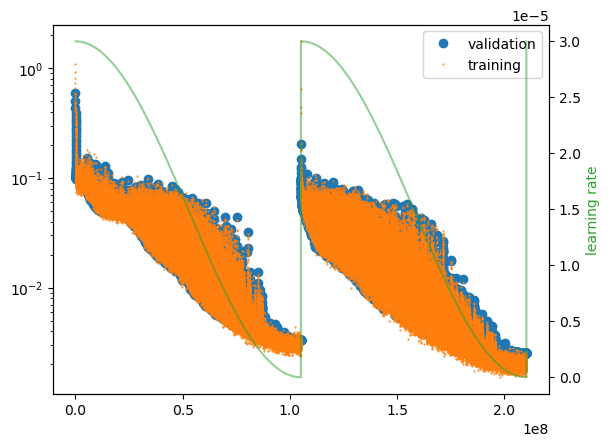

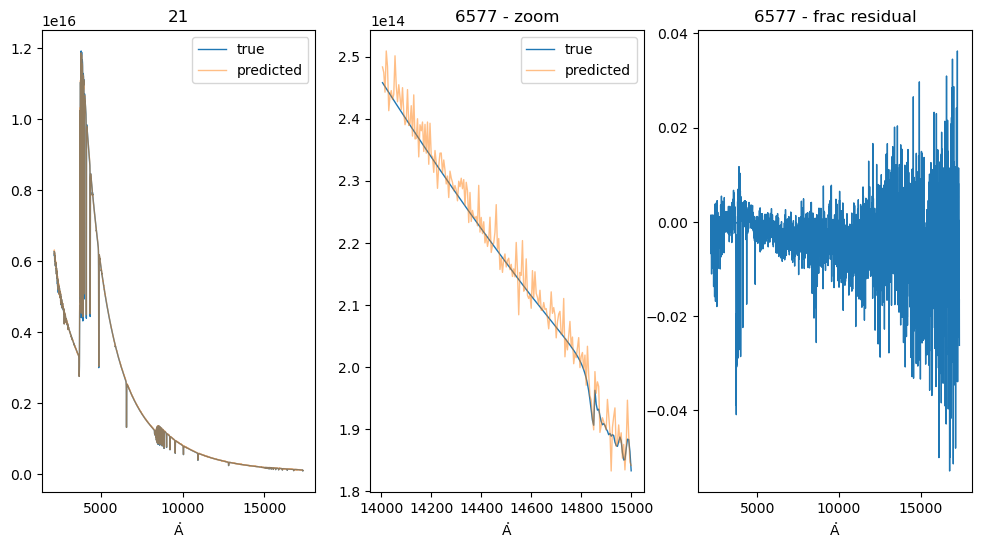

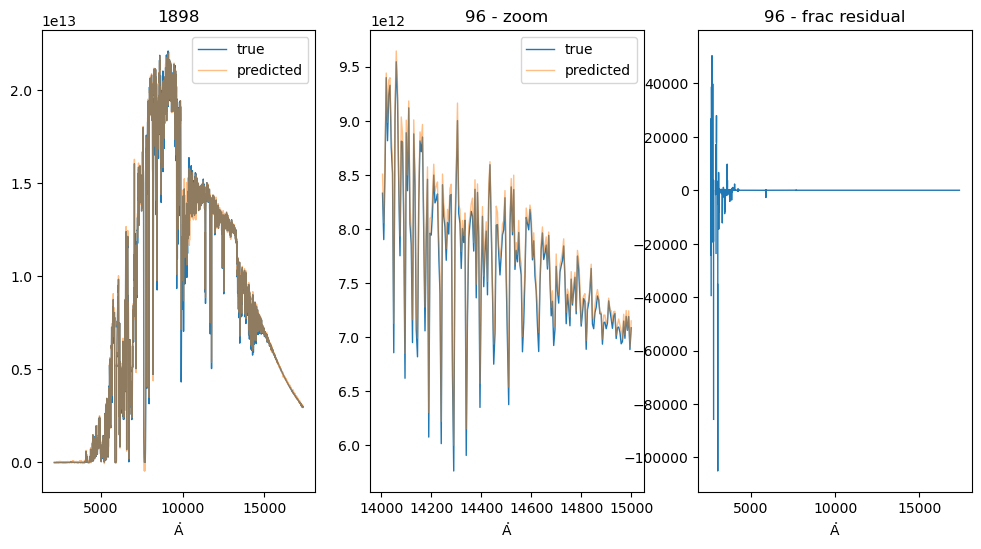

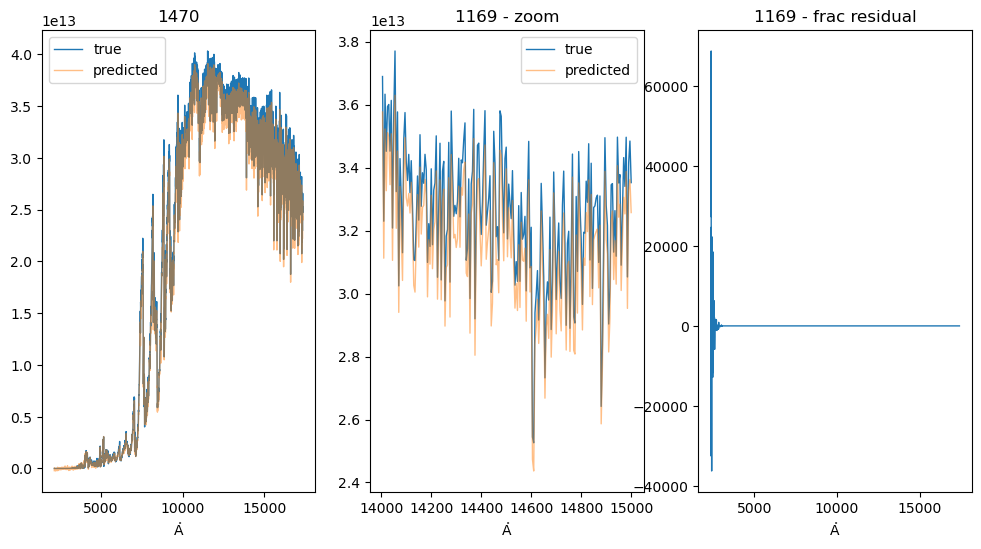

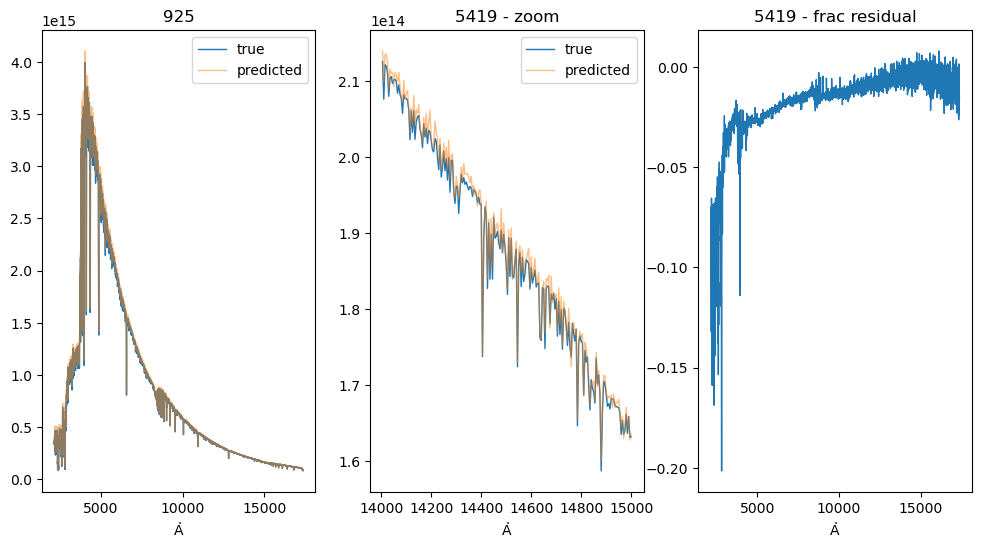

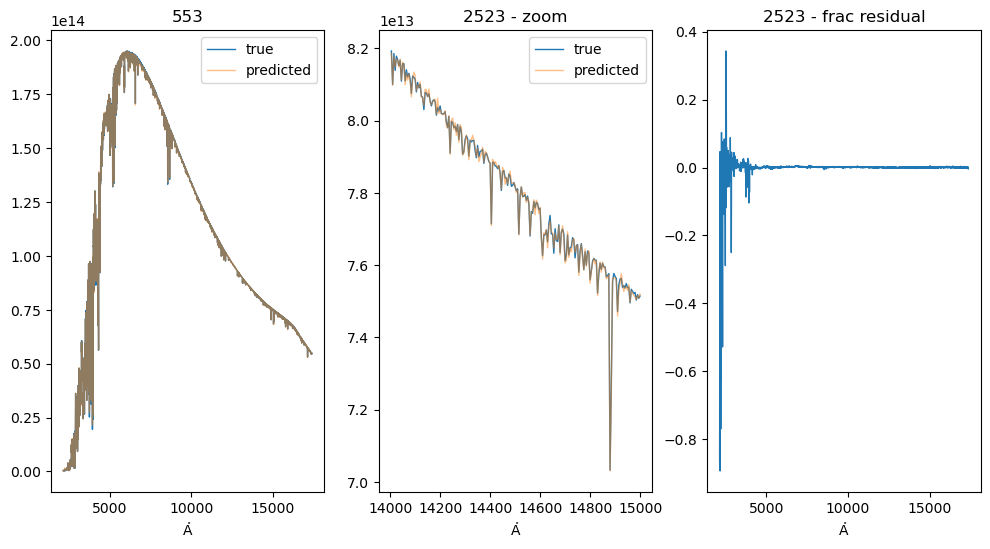

In [36]:
nperrestart = 20000
nrestarts = 2


model = SpectrumEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128, 256, 1024, 512, 256], 
                         resnet_nneurons=[ 256, 512, 2048, 8184, 2048, 512, 256 ])
print(sum(p.shape.numel() for p in model.parameters()) * 1e-6, 'M parameters')

model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)


class MyLoss(nn.Module):
    def __init__(self, l1weight=0.5, l2weight=0.5):
        super().__init__()
        
        self.l1 = nn.L1Loss()
        self.l2 = nn.MSELoss()
        self.l1w = l1weight
        self.l2w = l2weight
        
    def forward(self, x, y):
        return self.l1w*self.l1(x, y) + self.l2w*self.l2(x, y)
model.loss_fcn = MyLoss()

model = model.to(device, dtype=tensor_dtype)


valid, train, lrs, data_split =  model.train_and_validate(infeatures, fluxes, nperrestart*nrestarts, 1024,
                                                         optkwargs=dict(lr=3e-5,
                                                                        weight_decay=1e-3))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')

plot_sample_specs(model, data_split[0], descale=True);

In [259]:
p = Path('big_model_restricted.pth')
if not p.is_file():
    torch.save(model, p)

The higher frequencies are iffy but this is potentially good enough for photometry.  Lets try it!  First set up the integrals for each transmission, starting with some unit/etc tests:

In [119]:
x = u.Quantity(transmission['F275W']['Wavelength'], u.angstrom)
r = transmission['F275W']['Transmission']
fab = (1*u.ABflux).to(u.erg/u.s * u.cm**-2/u.angstrom, u.spectral_density(x))

np.sum(np.diff(x)*x[1:]*r[1:]*fab[1:]), integrate.simpson(r*fab*x, x)

(<Quantity 0.00202084 Angstrom erg / (s cm2)>,
 np.float64(0.002020874029477572))

In [127]:
integral_unit = r.unit*fab.unit*x.unit**2
integral_unit

Unit("Angstrom erg / (s cm2)")

In [123]:
%timeit np.sum(np.diff(x)*x[1:]*r[1:]*fab[1:])
%timeit integrate.simpson(r*fab*x, x)

102 μs ± 832 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
115 μs ± 783 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [185]:
ab_denominator = {}
for band, tab in transmission.items():
    x = u.Quantity(tab['Wavelength'], u.angstrom)
    r = tab['Transmission'].quantity
    fab = (1*u.ABflux).to(u.erg/u.s * u.cm**-2/u.angstrom, u.spectral_density(x))
    #
    ab_denominator[band] = integrate.simpson(r*fab*x, x) << (r.unit*fab.unit*x.unit**2)

ab_denominator

{'F275W': <Quantity 0.00202087 Angstrom erg / (s cm2)>,
 'F336W': <Quantity 0.00330585 Angstrom erg / (s cm2)>,
 'F475W': <Quantity 0.01144978 Angstrom erg / (s cm2)>,
 'F814W': <Quantity 0.01036934 Angstrom erg / (s cm2)>,
 'F110W': <Quantity 0.0233884 Angstrom erg / (s cm2)>,
 'F160W': <Quantity 0.01047841 Angstrom erg / (s cm2)>}

In [184]:
stmag_denominator = {}
for band, tab in transmission.items():
    x = u.Quantity(tab['Wavelength'], u.angstrom)
    r = tab['Transmission'].quantity
    fst = (1*u.STflux).to(u.erg/u.s * u.cm**-2/u.angstrom)
    stmag_denominator[band] = integrate.simpson(r*fst*x, x) << (r.unit*fst.unit*x.unit**2)

stmag_denominator

{'F275W': <Quantity 0.0004948 Angstrom erg / (s cm2)>,
 'F336W': <Quantity 0.0012408 Angstrom erg / (s cm2)>,
 'F475W': <Quantity 0.00860605 Angstrom erg / (s cm2)>,
 'F814W': <Quantity 0.02238926 Angstrom erg / (s cm2)>,
 'F110W': <Quantity 0.10379443 Angstrom erg / (s cm2)>,
 'F160W': <Quantity 0.08257361 Angstrom erg / (s cm2)>}

In [195]:
_resampler = manipulation.FluxConservingResampler()
def synthetic_photometry(spec, d=10*u.pc, denom=ab_denominator):
    results = {}
    for band, tab in transmission.items():
        x = u.Quantity(tab['Wavelength'], u.angstrom)
        r = tab['Transmission'].quantity

        newspec = _resampler(spec, x)
        i = (r*newspec.flux*x).to(denom[band].unit/x.unit)
        surfaceflux = integrate.simpson(i, x) << integral_unit
        totflux = surfaceflux *4*np.pi*(header['PHXREFF']*u.cm)**2
        absflux =  totflux/(4*np.pi*d**2)
        
        results[band] = -2.5*np.log10(absflux/denom[band])

    return results


# test for a ~sun-like star
idx = 4150
p = goodspecpaths[idx]
print(infeatures[idx])

header = dict(fits.getheader(p, ext=0))
spec = Spectrum1D(spectral_axis=model_wls, flux=fits.getdata(p, ext=0) << u.Unit(header['BUNIT']))
synthetic_photometry(spec)

tensor([5.8000e+03, 4.5000e+00, 0.0000e+00])


{'F275W': <Quantity 8.37105786>,
 'F336W': <Quantity 6.70910447>,
 'F475W': <Quantity 5.23175679>,
 'F814W': <Quantity 4.67764626>,
 'F110W': <Quantity 4.69138731>,
 'F160W': <Quantity 4.78419839>}

https://mips.as.arizona.edu/~cnaw/sun_2006.html says sun is ~4.6 om F814W ab mags so this is consistent! Now do some comparisons between the real spectra and their emulated versions:

In [243]:
denom = ab_denominator
table_dict = defaultdict(list)

for idx in tqdm(np.random.permutation(len(goodspecpaths))[:150]):
    p = goodspecpaths[idx]
    inf = infeatures[idx]
    table_dict['idx'].append(idx)
    for nm, i in zip(infeature_names, inf):
        table_dict[nm].append(i)
    
    header = dict(fits.getheader(p, ext=0))
    truespec = Spectrum1D(spectral_axis=model_wls, flux=fits.getdata(p, ext=0) << u.Unit(header['BUNIT']))
    truephot = synthetic_photometry(truespec, denom=denom)
    for ph, val in truephot.items():
        table_dict[ph+'_true'].append(val)

    emspec = Spectrum1D(spectral_axis=data_wls, flux=model.forward_descale(inf).cpu().detach()[0] << spec.flux.unit)
    emphot = synthetic_photometry(emspec, denom=denom)
    for ph, val in emphot.items():
        table_dict[ph+'_emul'].append(val)

    for ph in emphot.keys():
        table_dict[ph+'_diff'].append(table_dict[ph+'_emul'][-1] - table_dict[ph+'_true'][-1])

results = table.Table(table_dict)
results

  0%|          | 0/150 [00:00<?, ?it/s]

/tmp/ipykernel_23330/563349319.py:66: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = 10**teffpoly(np.log10(teff))
/home/erik/astro/phoenix/ml_generation/.pixi/envs/cuda/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


idx,Teff,logg,FeH,F275W_true,F336W_true,F475W_true,F814W_true,F110W_true,F160W_true,F275W_emul,F336W_emul,F475W_emul,F814W_emul,F110W_emul,F160W_emul,F275W_diff,F336W_diff,F475W_diff,F814W_diff,F110W_diff,F160W_diff
int64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3855,5600.0,0.5,-1.5,-1.9765038940825135,-3.531642097200296,-5.7824726115394585,-6.292647127432617,-6.334030368818919,-6.241311180494796,-2.122294667076086,-3.759347794161236,-5.786033445520799,-6.302747257927398,-6.333940777987208,-6.240306016594943,-0.14579077299357257,-0.2277056969609399,-0.0035608339813402168,-0.010100130494780757,8.959083171067306e-05,0.0010051638998529455
4372,6000.0,4.5,0.0,7.892333120620927,6.361614367057555,4.957665669209671,4.486411125320295,4.530849679580611,4.657131095951008,7.897734719212911,6.33715327558145,4.959911241092599,4.481145562030678,4.532046108582276,4.656634961662803,0.005401598591983969,-0.024461091476105423,0.0022455718829279547,-0.005265563289617248,0.0011964290016646117,-0.0004961342882046083
2474,4400.0,1.0,0.0,5.8834884852103535,1.8295106260360459,-1.8717148740292535,-3.259285358768049,-3.678146169348416,-3.8668311986475983,5.891871916701903,1.7800232671398561,-1.8801128538033238,-3.339958639499145,-3.680444841405527,-3.8681086691442856,0.008383431491549409,-0.049487358896189715,-0.008397979774070308,-0.08067328073109614,-0.002298672057110984,-0.0012774704966873607
1195,3300.0,1.5,0.5,12.937498331994426,7.383084076311867,4.425093747172227,0.7733270085617522,-0.8398624115379161,-1.4297004685556765,nan,7.317578547136837,4.410310139767867,0.7258223391468798,-0.8393100365124198,-1.4240319678354592,nan,-0.06550552917502994,-0.014783607404360133,-0.047504669414872414,0.0005523750254963211,0.0056685007202172955
3166,5000.0,0.5,-2.0,-0.579217697434995,-2.5055498729430017,-4.7004175947871465,-5.584029349539048,-5.743527926471769,-5.817783528627917,-0.544984365474644,-2.614610654972248,-4.716135238729828,-5.603134355213843,-5.761549564263363,-5.831540214225585,0.03423333196035094,-0.10906078202924618,-0.015717643942681825,-0.01910500567479545,-0.018021637791593825,-0.013756685597668294
7432,12000.0,2.0,0.0,-5.50462828117226,-5.692588513659004,-6.1865026700247245,-5.584590796944617,-5.135473433751599,-4.611230885909489,-5.503748663471308,-5.6929790321797835,-6.198690572115094,-5.599200175639427,-5.141140683580185,-4.6194123297404035,0.0008796177009520179,-0.00039051852077953697,-0.012187902090369462,-0.014609378694809827,-0.0056672498285861295,-0.00818144383091468
4936,6600.0,2.5,-1.5,1.2791678146725096,0.44111605711419766,-1.1552129394324622,-1.2856003999517882,-1.180366927423227,-0.9437261393862567,1.2613042792047688,0.38555991089575864,-1.1538581865673547,-1.2875714963146503,-1.180168373734992,-0.9445843356415675,-0.017863535467740776,-0.05555614621843902,0.0013547528651074447,-0.0019710963628620792,0.00019855368823495922,-0.0008581962553108058
4687,6300.0,5.0,-2.0,7.7507785525251816,6.86247636888851,5.949752921147412,5.575336490917858,5.643774542138118,5.787305616712386,7.743962297653121,6.8559783997086035,5.94793128646444,5.575642050141509,5.643053528326058,5.786049075968647,-0.006816254872060945,-0.0064979691799065264,-0.0018216346829715846,0.0003055592236504978,-0.000721013812060356,-0.001256540743739265
6260,9000.0,2.5,-4.0,-1.2902048639643036,-1.6239040671276406,-3.2173273788908405,-2.7274115513289447,-2.4378223178980125,-1.9469076362764437,-1.2928578940472348,-1.625994888112083,-3.2186197545899513,-2.7306042667066044,-2.438252428760374,-1.9448823651765113,-0.0026530300829312736,-0.002090820984442354,-0.0012923756991107815,-0.0031927153776596384,-0.0004301108623616656,0.0020252710999324464


In [252]:
for bandnm in transmission.keys():
    print(bandnm, np.nanmean(results[bandnm + '_diff']), np.nanstd(results[bandnm + '_diff']))

F275W -0.2525754242812975 1.0081723160990714
F336W -0.005195475749620013 0.22794894080483163
F475W -0.002942582013716499 0.02472981382331171
F814W -0.023031626481900654 0.03970459978214129
F110W 0.00010534374701696026 0.003761915592066185
F160W -5.7321194302189886e-05 0.004210465262472718


In [256]:
msk = results['Teff']> 3000
for bandnm in transmission.keys():
    print(bandnm, np.nanmean(results[msk][bandnm + '_diff']), np.nanstd(results[msk][bandnm + '_diff']))

F275W -0.04879827716601705 0.3753923110063412
F336W -0.019633249968610933 0.06545704990427594
F475W -0.000495139640968068 0.009043662620077204
F814W -0.02082632257396803 0.04009883927832573
F110W 0.00018352289530792815 0.003912642603666062
F160W 1.1399363302251405e-05 0.0043610832876136455


In [255]:
msk = results['Teff']> 4000
for bandnm in transmission.keys():
    print(bandnm, np.nanmean(results[msk][bandnm + '_diff']), np.nanstd(results[msk][bandnm + '_diff']))

F275W -0.024762708032115863 0.0887652480549921
F336W -0.027307615824706134 0.06191349480080847
F475W 0.0002040195934640197 0.008575927513116364
F814W -0.016498054251861235 0.039499887925490244
F110W 8.781553139598014e-05 0.003579454653153386
F160W -0.000280933312020176 0.004354500070193941


In [257]:
msk = results['Teff']> 5800
for bandnm in transmission.keys():
    print(bandnm, np.nanmean(results[msk][bandnm + '_diff']), np.nanstd(results[msk][bandnm + '_diff']))

F275W -0.00022160168153324356 0.013072907282592137
F336W -0.019243080232032885 0.030007521784650423
F475W 0.0007396537489476624 0.00500876151091981
F814W -0.007535124863916666 0.013545450605351972
F110W 0.00022010048361923083 0.002378263676593924
F160W -2.419173949682607e-05 0.0030432710714044897


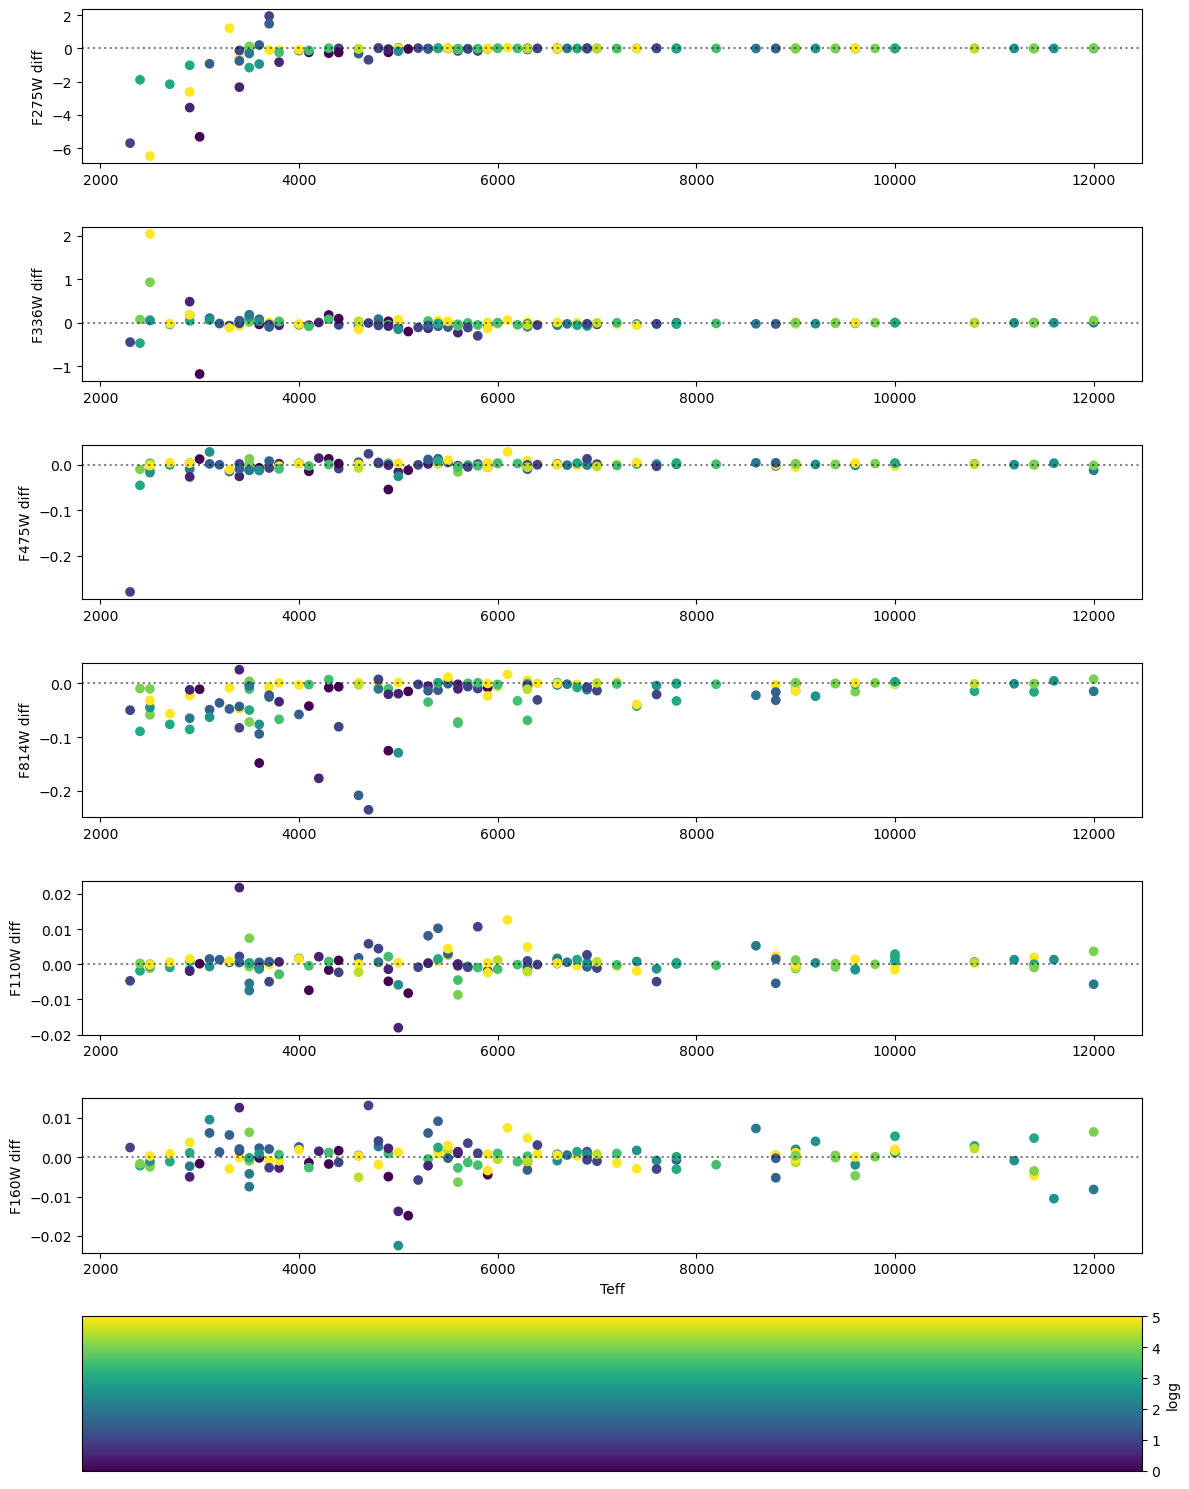

In [248]:
fig, axs = plt.subplots(len(transmission)+1, 1, figsize=(12, 15))
for bandnm, ax in zip(transmission.keys(), axs.ravel()):
    sc = ax.scatter(results['Teff'], results[bandnm + '_diff'], c=results['logg'], vmin=0, vmax=5)
    ax.set_ylabel(f'{bandnm} diff')
    ax.axhline(0, c='k', alpha=.5, ls=':')

ax.set_xlabel('Teff')
plt.colorbar(sc, cax=axs.ravel()[-1]).set_label('logg') 
fig.tight_layout()